In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import derivative
from scipy.optimize import root
from functools import partial
import math

# Homework CNS Week 2
## Stefan Iacob (s4575121), Bas Krahmer (s4616553), Davide Sabeddu (s1032453)

## Assignment 1
### a)



In [129]:
def f(Y, I):
    v, u = Y
    return np.array([(0.7*(v+60)*(v+40)-u+I)/100, 0.03*(-2*(v+60)-u)])

def mod_euler(func, t_current, y_current, h, I, spikes):
    if (y_current[0]>35):
        y_current[0] = -50
        y_current[1] += 100
        spikes += 1
    y_approx = y_current + h * func(y_current, I)
    y_next = y_current + 0.5 * h * (func(y_current, I) + func(y_approx, I))
    t_next = t_current + h
    return t_next, y_next, spikes

### b)

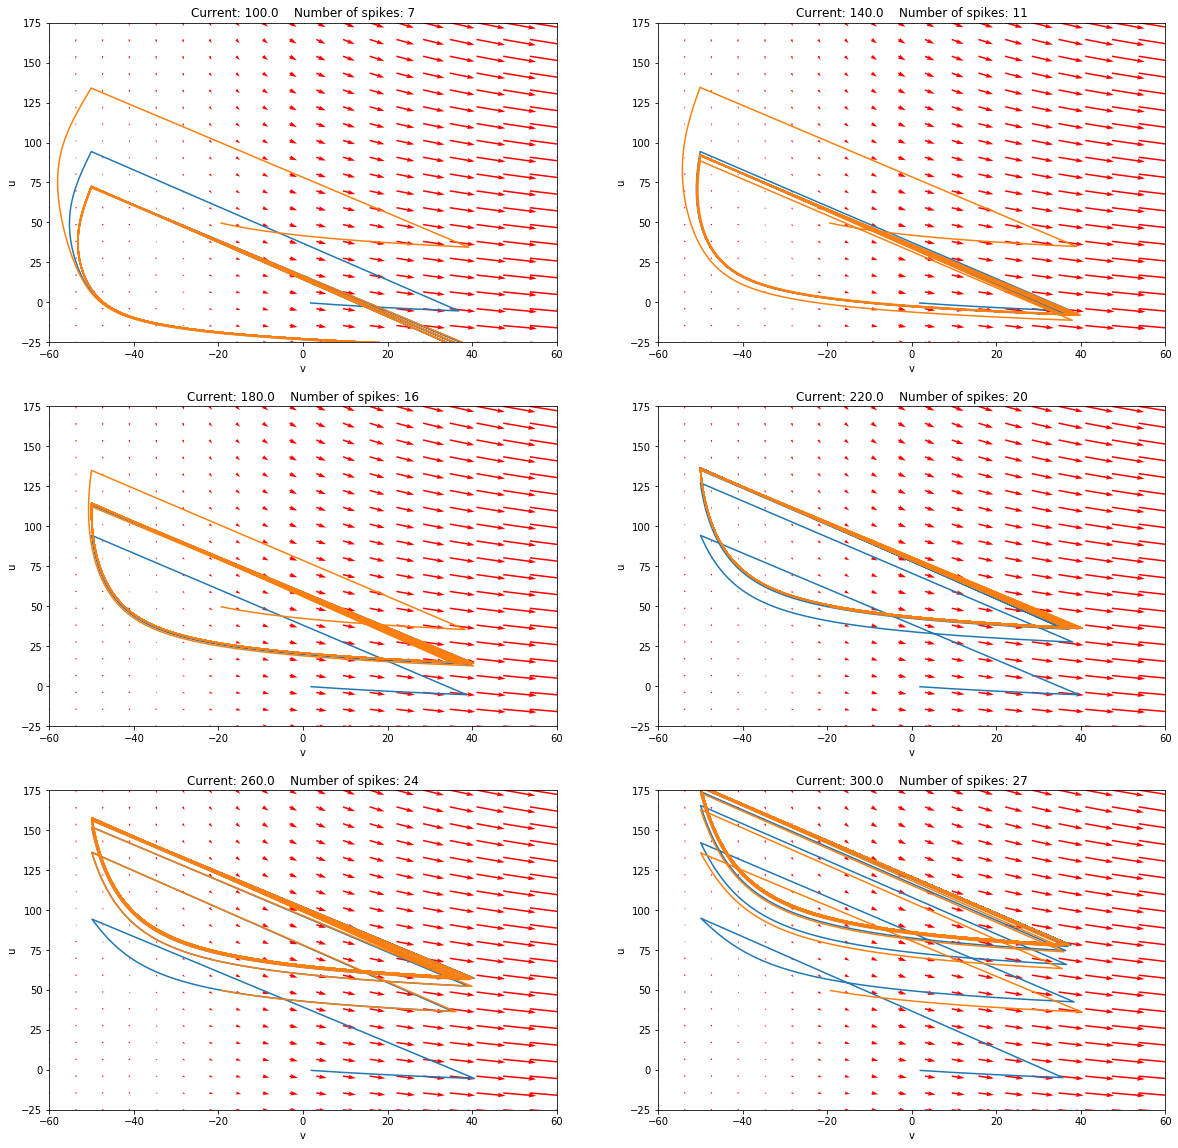

In [141]:
plt.rcParams['figure.figsize'] = [20, 20]
fig, ax = plt.subplots(3, 2)
current_list, spike_list = [], []

p_i = 0 # plot index
for I in np.linspace(100, 300, 6):
    # code below inspired from http://kitchingroup.cheme.cmu.edu/blog/2013/02/21/Phase-portraits-of-a-system-of-ODEs/
    ##########################################################################
    xlim = (-60, 60)
    ylim = (-25, 175)
    y1 = np.linspace(xlim[0], xlim[1], 20)
    y2 = np.linspace(ylim[0], ylim[1], 20)
    Y1, Y2 = np.meshgrid(y1, y2)
    v, u = np.zeros(Y1.shape), np.zeros(Y2.shape)
    NI, NJ = Y1.shape
    t = 0
    for i in range(NI):
        for j in range(NJ):
            x = Y1[i, j]
            y = Y2[i, j]
            yprime = f([x, y], I)
            v[i,j] = yprime[0]
            u[i,j] = yprime[1]
    ax[int(p_i/2), p_i%2].quiver(Y1, Y2, v, u, color='r')
    ax[int(p_i/2), p_i%2].set_xlabel('v')
    ax[int(p_i/2), p_i%2].set_ylabel('u')
    ax[int(p_i/2), p_i%2].set_xlim(xlim)
    ax[int(p_i/2), p_i%2].set_ylim(ylim)
    ##########################################################################


    for y_start in np.array([[0,0], [-20,50]]):

        length = 5000
        step_size = 0.1
        y = y_start
        Y = np.zeros((2,length))
        spikes = 0
        for i in range(length):
            t, y, spikes = mod_euler(f, t, y, step_size, I, spikes)
            Y[:,i] = y

        ax[int(p_i/2), p_i%2].plot(Y[0,:], Y[1,:])
        ax[int(p_i/2), p_i%2].set_title('Current: ' + str(I) + '    Number of spikes: ' + str(spikes))
    
    current_list.append(I)
    spike_list.append(spikes)
    p_i += 1

After spike onset, the value of u shoots up while the value of v shoots down. As u increases, the derivative of v increases too. With a higher derivative of v, the neuron spikes faster. With higher v values however, u also decreases faster. The neuron finds a stable tradeoff between these two derivatives, forming a limit cycle. This is illustrated in the above graphs: for different current values I, the bifurcation shows a limit cycle for different combinatory values of u and v.

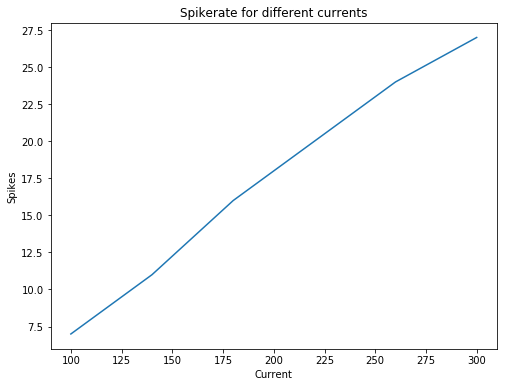

In [143]:
plt.rcParams['figure.figsize'] = [8, 6]
plt.plot(current_list, spike_list)
plt.title('Spikerate for different currents')
plt.xlabel('Current')
plt.ylabel('Number of spikes after 5000 steps with step size 0.1')
plt.show()

The plot above shows how the spikerate changes along with current values. This is based on the spikerates of the 6 graphs earlier, and thus not an exact relationship. It is however a valid approximation, which suggests that the number of spikes linearly increases with the current. To get a more precise measurement it would be required to start counting the number of spikes for more intervals, and discard the initial steps necessary to get on the limit cycle.

Since the neuron consistently spikes with the same inter-spike-interval, we hypothesize that it the neuron shows steady-state spiking behavior.

### c)

### d)

## Assignment 2
### a)

### b)